In [40]:
import osmnx as ox # Using version 0.14.0
import networkx as nx
import plotly.graph_objects as go
import numpy as np

from PIL import Image
from PIL.ExifTags import TAGS
import random

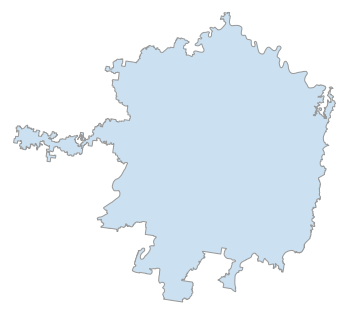

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

In [41]:
city = ox.gdf_from_place('Sydney, Australia', which_result=1)
ox.plot_shape(ox.projection.project_gdf(city))

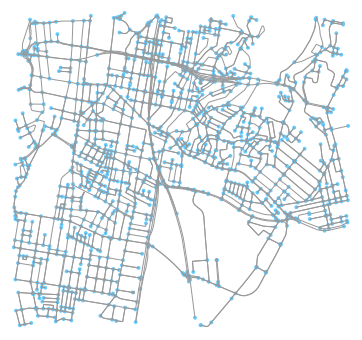

(<Figure size 554.657x432 with 1 Axes>, <AxesSubplot:>)

In [42]:
north, east, south, west = -33.8700, 151.240, -33.9, 151.2014

G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive')
ox.plot_graph(G)

In [43]:
def getLatLong(value):
    dLat = float(value[2][0])
    mLat = float(value[2][1])
    sLat = float(value[2][2])
    
    dLong = float(value[4][0])
    mLong = float(value[4][1])
    sLong = float(value[4][2])
    
    
    lat = dLat + (mLat / 60.0) + (sLat / 3600.0)
    long = dLong + (mLong / 60.0) + (sLong / 3600.0)
    
    if (value[1] != 'N'):
        lat *= -1
    if (value[3] != 'E'):
        long *= -1

    return lat, long

In [44]:
origin_point = (random.uniform(-33.8700, -33.9), random.uniform(151.2014, 151.240))
img = Image.open('images/test.jpg')
exifData = img._getexif()
lat, lon = getLatLong(exifData[34853])
destination_point = (lat, lon)
print(lat, lon)

origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)

origin_node, destination_node

-33.88416800752481 151.2081923653715


(1825618868, 1845022467)

In [45]:
route = nx.shortest_path(G, origin_node, destination_node, weight = 'length')
route

[1825618868,
 1825619146,
 1844912703,
 1845203354,
 1845203351,
 1829857114,
 6338973750,
 1838661438,
 1838649884,
 1838649886,
 20958788,
 15448408,
 15448410,
 1849264997,
 26410755,
 13887505,
 26374881,
 1842883010,
 1842883008,
 1846081815,
 1860824833,
 13887511,
 1829857208,
 1829857202,
 1829857168,
 1829857164,
 247995501,
 1829857145,
 1829857220,
 1845022467]

In [46]:
long = []
lat = []
for i in route:
    point = G.nodes[i]
    long.append(point['x'])
    lat.append(point['y'])

In [47]:
def plot_path(lat, long, origin_point, destination_point):
        # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

In [48]:
plot_path(lat, long, origin_point, destination_point)

In [49]:
def node_list_to_path(G, node_list):
    """
    Given a list of nodes, return a list of lines that together
    follow the path
    defined by the list of nodes.
    Parameters
    ----------
    G : networkx multidigraph
    route : list
        the route as a list of nodes
    Returns
    -------
    lines : list of lines given as pairs ( (x_start, y_start), 
    (x_stop, y_stop) )
    """
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), 
                   key=lambda x: x['length'])
        # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
    return lines
# getting the list of coordinates from the path 
# (which is a list of nodes)
lines = node_list_to_path(G, route)
long2 = []
lat2 = []
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [50]:
print("Length of lat: ", len(lat))
print("Length of lat2: ", len(lat2))

Length of lat:  30
Length of lat2:  125


In [51]:
plot_path(lat2, long2, origin_point, destination_point)